{'star': [{'quantum_greedy': 0.0, 'greedy_optimal': 0.002673517519460912, 'quantum_optimal': 0.002673517519460912, 'nodes': 3}, {'quantum_greedy': 0.0, 'greedy_optimal': 1.2333414044292096e-16, 'quantum_optimal': 1.2333414044292096e-16, 'nodes': 4}, {'quantum_greedy': 0.0, 'greedy_optimal': 4.058824002009291e-06, 'quantum_optimal': 4.058824002009291e-06, 'nodes': 5}, {'quantum_greedy': 0.0, 'greedy_optimal': 1.1116471107329491e-06, 'quantum_optimal': 1.1116471107329491e-06, 'nodes': 6}, {'quantum_greedy': 1.6327287532380827e-08, 'greedy_optimal': 0.0, 'quantum_optimal': 1.6327287532380827e-08, 'nodes': 7}, {'quantum_greedy': 7.775626097194873e-10, 'greedy_optimal': 3.6008410254003215e-16, 'quantum_optimal': 7.775629698035896e-10, 'nodes': 8}, {'quantum_greedy': 2.395247088663008e-10, 'greedy_optimal': 3.6791466221443787e-16, 'quantum_optimal': 2.395250767809629e-10, 'nodes': 9}, {'quantum_greedy': 0.0, 'greedy_optimal': 2.9620570531925084e-16, 'quantum_optimal': 2.9620570531925084e-16,

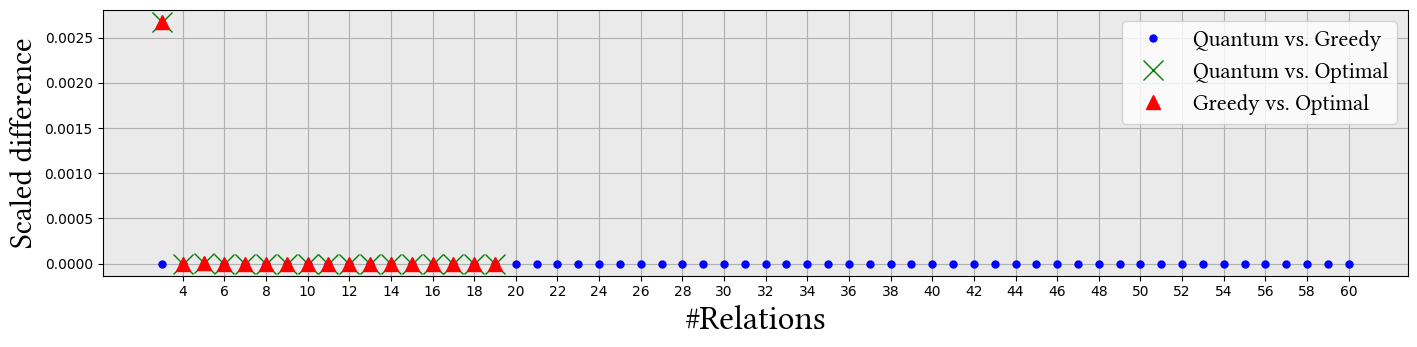

In [1]:
import os
import json
from pathlib import Path
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from collections import defaultdict

fpath = Path(mpl.get_data_path(), "C:\\Users\\valte\\OneDrive - University of Helsinki\\Desktop\\linux_libertine\\LinLibertine_R.ttf")
custom_font = FontProperties(fname=fpath, size=16)

def load_json_files(folder_path):
    json_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            with open(os.path.join(folder_path, filename), 'r') as file:
                data = json.load(file)
                json_files.append((filename, data))
    return json_files


def parse_filename(filename):
    parts = filename.split('_')
    graph_type = parts[1]
    num_nodes = int(parts[2])
    return graph_type, num_nodes


def extract_data(json_files):
    data = defaultdict(lambda: {'optimal': [], 'greedy': [], 'quantum': [], 'nodes': []})
    
    for filename, content in json_files:
        graph_type, num_nodes = parse_filename(filename)
        content = list(content.values())[0]
        if content:
            if 'optimal_cost' in content:
                if content['optimal_cost'] == 0:
                    if content['graph_aware_dynamic_programming_cost'] == 0:
                        data[graph_type]['optimal'].append(None)
                    else:
                        data[graph_type]['optimal'].append(content['graph_aware_dynamic_programming_cost'])
                else:
                    data[graph_type]['optimal'].append(content['optimal_cost'])
            if 'graph_aware_greedy_cost' in content:
                data[graph_type]['greedy'].append(content['graph_aware_greedy_cost'])
            if 'cost' in content:
                data[graph_type]['quantum'].append(content['cost'])
            data[graph_type]['nodes'].append(num_nodes)
    
    # For each graph type, sort the data by number of nodes
    for graph_type, values in data.items():
        sort_order = sorted(range(len(values['nodes'])), key=lambda k: values['nodes'][k])
        for key in values.keys():
            values[key] = [values[key][i] for i in sort_order]
    
    return data

def compute_relative_differences(data):
    res = {}
    for graph_type, values in data.items():
        quant = values['quantum']
        greed = values['greedy']
        opt = values['optimal']
        nodes = values['nodes']
        relative_differences = [{
                    'quantum_greedy': (abs(quant - greed) / max(quant, greed)),
                    'greedy_optimal': (abs(greed - opt) / max(greed, opt)) if opt is not None else None,
                    'quantum_optimal': (abs(quant - opt) / max(quant, opt)) if opt is not None else None,
                    "nodes": n} for quant, greed, opt, n in zip(quant, greed, opt, nodes)]
        res[graph_type] = relative_differences
    return res
    

def plot_accuracies(data):
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 'x', '^', 's']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markersizes = [5, 15, 10]
    linewidths = [4, 3, 2]

    for graph_type, relative_differences in data.items():
        if graph_type == 'clique':
            fig_width = 11.4
        else:
            fig_width = 2*7.14
        fig, ax = plt.subplots(figsize=(fig_width, (1/4)*fig_width))
        smoke_gray = '#eaeaea'
        ax.set_facecolor(smoke_gray)
        print(relative_differences)
        nodes = [values['nodes'] for values in relative_differences]
        for i, values in enumerate(relative_differences):
            if False:
                if values[key]:
                    plt.plot(
                        values['nodes'], 
                        values[key], 
                        label=key.capitalize(), 
                        linestyle=line_style, 
                        marker=marker, 
                        color=colors[i % len(colors)],
                        linewidth=linewidths[i % len(linewidths)],
                        markersize=markersizes[i % len(markersizes)],
                        alpha=0.7
                    )
            else:
                quant_greed = values['quantum_greedy']
                quant_opt = values['quantum_optimal']
                greed_opt = values['greedy_optimal']
                
                if quant_greed is not None:
                    plt.plot(values["nodes"], quant_greed, marker=markers[0], color=colors[0], markersize=markersizes[0], linestyle='', label=f'Quantum vs. Greedy' if i == 0 else "")
                if quant_opt is not None:
                    plt.plot(values["nodes"], quant_opt, marker=markers[1], color=colors[1], markersize=markersizes[1], linestyle='', label=f'Quantum vs. Optimal' if i == 0 else "")
                if greed_opt is not None:
                    plt.plot(values["nodes"], greed_opt, marker=markers[2], color=colors[2], markersize=markersizes[2], linestyle='', label=f'Greedy vs. Optimal' if i == 0 else "")
        
        
        # Set scientific notation on the y-axis
        #ax = plt.gca()  # Get current axis
        #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Force scientific notation

        # Add a note to indicate the scaling of values
        #plt.text(0.5, 0.1, 'Y-axis values are scaled (e.g., 0.02 represents 0.002)', 
        #        fontsize=12, ha='center', transform=plt.gca().transAxes)
        
        #plt.title(f'Accuracies for {graph_type}', fontsize=16)
        plt.xlabel('#Relations', font=fpath, fontsize=24)
        
        x_ticks = range(min(nodes), max(nodes) + 1)
        if graph_type == 'clique':
            plt.xticks(x_ticks)
        else:
            plt.xticks(x_ticks[1::2])
        
        plt.ylabel('Scaled difference', font=fpath, fontsize=22)
        #plt.yscale('log')
        plt.legend(prop=custom_font)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figures/{graph_type}_accuracies.png', dpi=400)
        #plt.show()

# Main execution
graphs = ['chain', 'cycle', 'clique', 'tree', 'star']
graph_type = graphs[4]
folder_path = '..\\results\\heuristic_1\\gurobi\\' + graph_type  # Replace with your folder path
json_files = load_json_files(folder_path)
data = extract_data(json_files)
relative_differences = compute_relative_differences(data)
print(relative_differences)
plot_accuracies(relative_differences)
